# Neural Network from scratch
This was an assignment for my deep learning course. I had to code a neural network from scratch (that is, using tensors only for computing, and doing differentiation and back-propagation by hand). All the code is mine, except in the first part `simulation of the data`.

In [1]:
import numpy as np
import torch
import sklearn
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

## Simulation of the data

In [3]:
def load_data(n_samples=500):
    return make_gaussian_quantiles(
        mean=None,
        cov=0.7,
        n_samples=n_samples,
        n_features=2,
        n_classes=2,
        shuffle=True,
        random_state=42,
    )

In [4]:
X, y = load_data()

print(X[:10, :])
print(y[:10])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

[[-1.13773727  0.62436053]
 [-0.75970745 -1.18161805]
 [-0.82471758  0.42171557]
 [-0.09398039 -0.18487643]
 [-0.80731289  0.57399183]
 [ 0.67980788  1.13471182]
 [-1.70521733 -0.84342552]
 [ 1.57461467  1.12565917]
 [-0.22579357 -0.81889248]
 [ 0.97317262  0.00856159]]
[1 1 0 0 1 1 1 1 0 1]


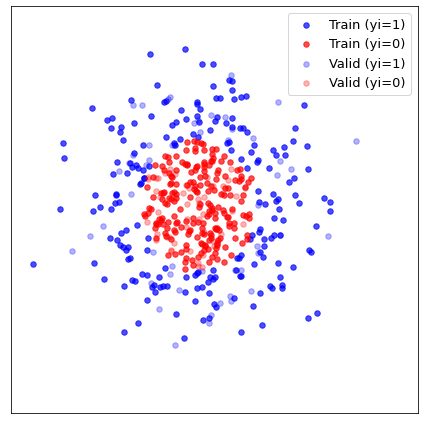

In [5]:
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def plot_data(X, y, xy_labels=True, label=None, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    if label is not None:
        plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=label + " (yi=1)", **kwargs)
        plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=label + " (yi=0)", **kwargs)
    plt.xticks(())
    plt.yticks(())
    plt.xlim(X[:, 0].min() - 1, X[:, 0].max() + 1)
    plt.ylim(X[:, 1].min() - 1, X[:, 1].max() + 1)

plt.figure(figsize=(6, 6))
plot_data(X_train, y_train, alpha=0.7, label="Train")
plot_data(X_test, y_test, alpha=0.3, label="Valid")
plt.legend(fontsize=13)
plt.tight_layout()

## A neural network class

### Architecture
- A `Layer` class, which does the initialization, forward and backward pass, and stores the gradients for one layer.
- A `NeuralNetwork` class which create the layers and connects them, propagating forward and backward through all of them. Also trains the network using full gradient descent.

I separated the two, so that it's easy to modulate. You can :
- Easily change the number and size of the layers.
- Choose a different activation function for each layer.
- Train with dynamic learning rate (for each layer and each epoch)

> Probably overkill compared to what was asked, but it was fun to do ! (but not easy)

### `Layer` class

This class implements one layer of a fully-connected network. The weights are initialized with the Xavier method. You need to provide `activation`, which contains the activation function and its jacobian. Two are defined below.

The layers are linked by calling, in a similar fashion to TensorFlow.

In [6]:
class Layer:
    def __init__(self, n_in, n_out, activation):
        '''n_in : size of the input
        n_out : size of the output
        activation : a tuple containing the activation function and its jacobian
        
        The layers can be linked together by calling the previous one:
        first = Layer(2, 10, relu)
        second = Layer(10, 5, relu)(first)
        output = Layer(5, 1, sigmoid)(second)
        This enables easy forward and backward passes between the layers.'''
        
        self.n_in = n_in
        self.n_out = n_out
        self.activation, self.Jactivation = activation
        
        # Xavier initialization for the weight tensor
        W = (torch.rand(self.n_out, self.n_in) - .5) * 2 # Uniform on [0,1]
        self.W = W * np.sqrt(6/(self.n_in + self.n_out)) # Xavier
        self.b = torch.zeros(n_out, 1)
        
        # The layers have a doubly-linked list structure.
        self.prev_layer = None
        self.next_layer = None
        
    def __call__(self, prev_layer):
        '''Links the layers together'''
        self.prev_layer = prev_layer
        prev_layer.next_layer = self
        return self
        
    def forward(self, input_tensor = None):
        '''Does a forward pass from this layer to the last Layer. If input_tensor isn't provided, the output of
        the previous Layer will be used.'''
        if input_tensor is None:
            try:
                input_tensor = self.prev_layer.output
            except:
                raise Exception("No tensor  provided for the input layer.")
        
        self.input = input_tensor.unsqueeze(2) # Adding a dimension to do batch matrix multiplication
        self.preactivation = (torch.matmul(self.W, self.input) + self.b).squeeze(2) # removing it
        self.output = self.activation(self.preactivation)
        
        # Continue the pass forward if this is not the last layer.
        if self.next_layer is not None:
            return self.next_layer.forward()
        # Return the output if this is the final layer
        return self.output

    
    def backward(self, grad_out = None):
        '''Propagates the gradients backward from this Layer and back, and stores them inside the object.
        In : grad_out : gradient of the output of the network, w.r.t the output of the layer. If not provided,
             will use the one calculated by the next layer.'''
        if grad_out == None:
            try:
                grad_out = self.next_layer.grad_in
            except:
                raise Exception("No output gradient provided for the last layer.")
        batch_size = grad_out.size()[0]        
        
        # Gradient of the output w.r.t the preactivation
        grad_preactivation = torch.matmul(grad_out.unsqueeze(1), self.Jactivation(self.preactivation))
        
        # Next we need the Jacobian of WX w.r.t the weights of W
        # It really isn't pretty, surely there is a better/faster way to do this...
        # The list comprehension makes one for each data in the batch, and they're stacked.
        JW = torch.stack([torch.block_diag(*([x]*self.n_out)) for x in self.input])
        # We use it to compute the gradient w.r.t the weights, and put it back into the shape of W
        self.grad_W = torch.matmul(grad_preactivation, JW.transpose(1,2)).view(batch_size, *self.W.size())

        # Gradient w.r.t the bias
        self.grad_b = grad_preactivation.transpose(1,2)
        # Gradient w.r.t the input, used by the previous layer
        self.grad_in = torch.matmul(grad_preactivation, self.W).squeeze(1)
        
        # Now we sum all the gradients of the batch and normalize by its size
        # We keep grad_in as is, because we need all the info to continue back-propagating !
        self.grad_W =  torch.sum(self.grad_W, 0) / batch_size
        self.grad_b =  torch.sum(self.grad_b, 0) / batch_size
        
        # Continue back-propagating if there are other layers.
        if self.prev_layer is not None:
            self.prev_layer.backward()

Next we define our `relu` and `sigmoid` activations. Using list comprehensions is inefficient and probably a bottleneck. However, it is sufficient for simple applications.

In [7]:
def Jrelu(X):
    # List comprehension is used to make one for every element of the batch
    return torch.stack([torch.diag((x>0).type(torch.float)) for x in X])
relu = (torch.nn.ReLU(), Jrelu)

sigm = torch.nn.Sigmoid()
def Jsigm(X):
    return torch.stack([torch.diag(sigm(x)*(1-sigm(x))) for x in X])
sigmoid = (sigm, Jsigm)

### `NeuralNetwork` class

Using the `Layer` class, we define a simple fully-connected neural network.

In [9]:
class NeuralNetwork:
    '''Implements a simple neural network with an arbitrary number of hidden layers.
    - n_in : size of the input
    - n_hidden : size(s) of the hidden layer(s). Can be an integer, or a list/tuple
    - n_out : size of the output
    
    By default, relu is used for every layer except the last one, for which sigmoid is preferred.
    Inference is done simply by calling.'''
    def __init__(self, n_in, n_hidden, n_out):
        if isinstance(n_hidden, int):
            n_hidden = [n_hidden]
        
        layers = [Layer(n_in, n_hidden[0], relu)] # start with the input layer
        for i in range(len(n_hidden)-1):          # add every hidden layer
            layers.append(Layer(n_hidden[i], n_hidden[i+1], relu)(layers[i]))
        
        # With chaining, we only need to keep references to the input and output layers.
        self.output_layer = Layer(n_hidden[-1], n_out, sigmoid)(layers[-1])
        self.input_layer = layers[0]
        
        # Variables to store the losses during training, used for plotting
        self.tra_losses = []
        self.val_losses = []
        
    def __call__(self, X):
        '''Convenience function to call the neural network for inference.'''
        return self.input_layer.forward(X)
        
    def update(self, lr):
        '''Do a gradient descent using the gradients computed using backward().
        - lr : the learning rate.'''
        layer = self.input_layer
        while layer is not None:
            layer.W -= lr * layer.grad_W
            layer.b -= lr * layer.grad_b
            layer = layer.next_layer

    
    def train(self, X_train, y_train, X_valid, y_valid, epochs, learning_rate, loss, verbose=True):
        '''Train the neural network using full gradient descent. Input:
        - training and validation datasets
        - number of epochs
        - learning_rate
        - loss : a loss function together with its gradient
        - verbose : whether to show training and validation losses during training'''
        l, grad_l = loss
        
        for e in range(epochs):
            # First propagate the data through the network
            out = self.input_layer.forward(X_train)
            # Then back-propagate from the gradient of the loss w.r.t the output of the network 
            self.output_layer.backward(grad_l(out, y_train))
            # Finally, update the layers' weights and biases according to the learning rate
            self.update(learning_rate)
            
            # Compute and store the losses
            tra_loss = l(out, y_train)
            self.tra_losses.append(tra_loss)
            out = self.input_layer.forward(X_valid) # We need a new forward pass to compute the validation loss
            val_loss = l(out, y_valid)
            self.val_losses.append(val_loss)
            
            if verbose:
                print(f'Epoch {e} : tra_loss={tra_loss}\tval_loss={val_loss}')
            
    def plot_history(self):
        '''Plot the training and validation losses.'''
        fig, ax = plt.subplots()
        ax.plot(self.tra_losses, label='Training loss')
        ax.plot(self.val_losses, label='Validation loss')
        leg = ax.legend()
        plt.xlabel('Epochs')
        plt.ylabel('Loss')

Finally we need some losses :
- `quadratic` was useful for testing.
- `cross_entropy` only works for one dimension, and is used for the toy example.

In [10]:
def quad_loss(out, true):
    return .5 * torch.sum(torch.pow(out-true, 2)) / out.shape[0]
quadratic = (quad_loss, lambda a, b: a-b)


def cross_entropy_loss(out, true):
    out = torch.clamp(out, min=.0001, max=.9999) # To prevent the logarithm from overflowing
    return -torch.sum(torch.mul(torch.log(out), true) + torch.mul(torch.log(1- out),  (1 - true))) / true.shape[0]

def cross_entropy_deriv(out, true):
    # Only works in one dimension !
    # This division is issue-prone and can lead to overflow if values are too close to 0 or 1
    out = torch.clamp(out, min=.0001, max=.9999) # To prevent overflow
    return -true/out + (1-true)/(1 -out)
            
cross_entropy = (cross_entropy_loss, cross_entropy_deriv)

**QUESTION.** Train your neural network, modify your code to save the training and validation error along the gradient descent iterations and plot them. You should also print the train and validation errors during training.

In [11]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float().unsqueeze(1) # Adding the batch dimension
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float().unsqueeze(1) # Adding the batch dimension

In [12]:
nn = NeuralNetwork(2, 10, 1)

In [13]:
history = nn.train(
    X_train_torch,
    y_train_torch,
    X_valid_torch,
    y_valid_torch,
    epochs=100,
    learning_rate=1,
    loss=cross_entropy,
)

Epoch 0 : tra_loss=0.7000555992126465	val_loss=0.6788493394851685
Epoch 1 : tra_loss=0.6767863631248474	val_loss=0.6630710363388062
Epoch 2 : tra_loss=0.6622577905654907	val_loss=0.6510263085365295
Epoch 3 : tra_loss=0.650636613368988	val_loss=0.6408144235610962
Epoch 4 : tra_loss=0.6401720643043518	val_loss=0.6314496397972107
Epoch 5 : tra_loss=0.6301196217536926	val_loss=0.6221927404403687
Epoch 6 : tra_loss=0.619898796081543	val_loss=0.6121058464050293
Epoch 7 : tra_loss=0.6087895035743713	val_loss=0.6032915711402893
Epoch 8 : tra_loss=0.5986582636833191	val_loss=0.5955140590667725
Epoch 9 : tra_loss=0.5894231200218201	val_loss=0.5874218940734863
Epoch 10 : tra_loss=0.5803666114807129	val_loss=0.5791914463043213
Epoch 11 : tra_loss=0.5714167356491089	val_loss=0.5709006786346436
Epoch 12 : tra_loss=0.5623477697372437	val_loss=0.5624016523361206
Epoch 13 : tra_loss=0.553041934967041	val_loss=0.5536017417907715
Epoch 14 : tra_loss=0.543511688709259	val_loss=0.5446388125419617
Epoch 15 

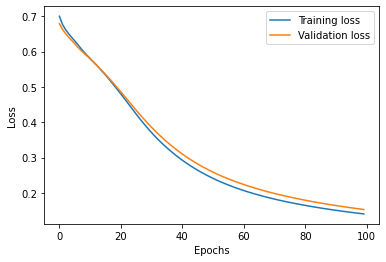

In [14]:
nn.plot_history()

## Assessment of your model

**QUESTION.** Use and modify the plotting functions from this notebook and the ones from `tutorial01` in order to plot the data together with the **predicted probabilities** of your neural network for inputs in a grid covering the input features space (as we did in `tutorial01`). Also, display on the plot the AUC-ROC metric obtained by your neural net.

In [15]:
# Code from tutorial01
def plot_data(ax, X, y, xy_labels=True, **kwargs):
    X_1 = X[y == 1]
    X_0 = X[y == 0]
    plt.scatter(X_1[:, 0], X_1[:, 1], c="blue", s=30, label=r"$y_i=1$", **kwargs)
    plt.scatter(X_0[:, 0], X_0[:, 1], c="red", s=30, label=r"$y_i=-1$", **kwargs)
    ax.set_xticks(())
    ax.set_yticks(())
    if xy_labels:
        ax.set_xlabel(r"$x_{i,1}$", fontsize=15)
        ax.set_ylabel(r"$x_{i,2}$", fontsize=15)
    ax.set_xlim(X[:, 0].min() - 0.5, X[:, 0].max() + 0.5)
    ax.set_ylim(X[:, 1].min() - 0.5, X[:, 1].max() + 0.5)


def plot_probas(nn, ax, X, y, h=0.02, levels=10, colorbar=True):
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))    
    Z = nn(torch.Tensor(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    ct = ax.contourf(xx, yy, Z, cmap=cm, alpha=.7, levels=levels)
    if colorbar:
        cbar = plt.colorbar(ct)
        cbar.ax.set_xlabel("Output")

Let's compute AUC and accuracy :

In [16]:
pred = nn(X_valid_torch).numpy()

from sklearn.metrics import roc_auc_score
auc = roc_auc_score(y_test, pred)

correct = (pred+.5).astype(int).flatten() == y_test
acc = np.sum(correct)/correct.shape[0]

Text(1.5, -2.4, 'AUC: 0.9996')

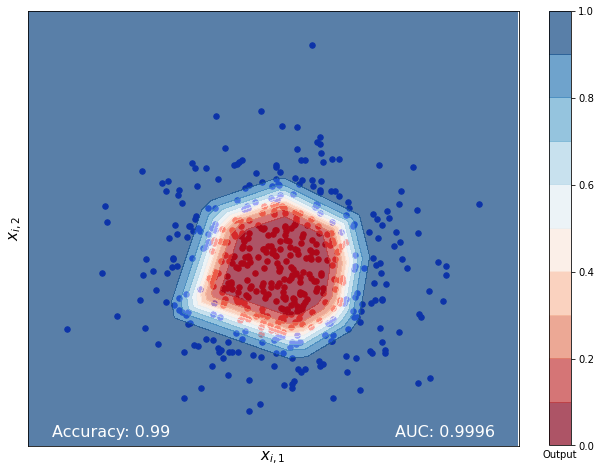

In [17]:
plt.figure(figsize=(11, 8))
ax = plt.axes()
plot_data(ax, X, y)
plot_probas(nn, ax, X, y)
plt.text(-2.9,-2.4, f"Accuracy: {acc:.2f}", fontsize=16, color="white")
plt.text(1.5,-2.4, f"AUC: {auc:.4f}", fontsize=16, color="white")

# Let's try with MNIST\*
(\* : a [smaller, simpler version](https://archive.ics.uci.edu/ml/datasets/optical+recognition+of+handwritten+digits), just for fun)

## Loading the data

In [21]:
from numpy import genfromtxt
train = genfromtxt('optdigits.tra', delimiter=',')
test = genfromtxt('optdigits.tes', delimiter=',')

In [22]:
X_train, y_train = train[:, :64], train[:, 64].reshape(-1, 1)
X_test, y_test = test[:, :64], test[:, 64].reshape(-1, 1)

Images are 8 by 8 pixels, 16 shades of gray :

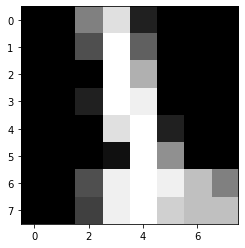

In [24]:
plt.imshow(X_train[42].reshape(8,8), cmap='gray')

We need to one-hot-encode the labels in order to use them with the last layer.

In [25]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(y_train)
y_train = ohe.transform(y_train).toarray()
y_test = ohe.transform(y_test).toarray()

In [26]:
X_train_torch = torch.from_numpy(X_train).float()
y_train_torch = torch.from_numpy(y_train).float()
X_valid_torch = torch.from_numpy(X_test).float()
y_valid_torch = torch.from_numpy(y_test).float()

In [27]:
y_train_torch[:10]

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])

## Creating the neural network

In [38]:
nn = NeuralNetwork(64, [30, 30, 30], 10)

Because this is a multi-class classification problem, it makes more sense use softmax as the final activation.

In [39]:
softmax = torch.nn.Softmax(dim=-1)

In [40]:
# Very slow because of the list comprehensions
def Jsoftmax(X): # Jacobian of the softmax activation. It's not diagonal like the two previous ones.
    soft = softmax(X)
    diag = torch.stack([torch.diag(s) for s in soft])
    return diag - torch.stack([torch.matmul(s.unsqueeze(1), s.unsqueeze(0)) for s in soft])

In [41]:
nn.output_layer.activation = softmax
nn.output_layer.Jactivation = Jsoftmax

## Training and results

In [44]:
nn.train(
    X_train_torch,
    y_train_torch,
    X_valid_torch,
    y_valid_torch,
    epochs=50,
    learning_rate=.1,
    loss=quadratic
    )

Epoch 0 : tra_loss=0.042485401034355164	val_loss=0.06396401673555374
Epoch 1 : tra_loss=0.03879809007048607	val_loss=0.06383474916219711
Epoch 2 : tra_loss=0.03854314237833023	val_loss=0.06374220550060272
Epoch 3 : tra_loss=0.03831776976585388	val_loss=0.06362895667552948
Epoch 4 : tra_loss=0.03810214623808861	val_loss=0.06350696831941605
Epoch 5 : tra_loss=0.03789146617054939	val_loss=0.06339012831449509
Epoch 6 : tra_loss=0.037684157490730286	val_loss=0.06326103955507278
Epoch 7 : tra_loss=0.03747983276844025	val_loss=0.06313629448413849
Epoch 8 : tra_loss=0.03727882355451584	val_loss=0.0630042776465416
Epoch 9 : tra_loss=0.03708067908883095	val_loss=0.06286625564098358
Epoch 10 : tra_loss=0.03688521310687065	val_loss=0.06273627281188965
Epoch 11 : tra_loss=0.03669294714927673	val_loss=0.062604621052742
Epoch 12 : tra_loss=0.03650350123643875	val_loss=0.0624723955988884
Epoch 13 : tra_loss=0.03631826862692833	val_loss=0.062343016266822815
Epoch 14 : tra_loss=0.036136262118816376	val_

The network was trained three times for 50 epochs, with learning rate of .3, .2 and .1 (by running the above cell three times).
It's quite slow (~1sec/epoch), but it *does* work.

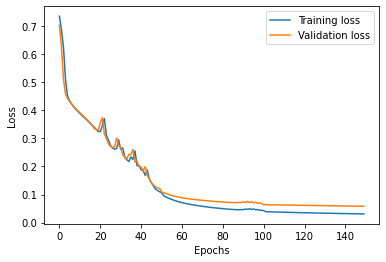

In [45]:
nn.plot_history()

There is no clear overfit, but not much performance is to be gained by further training the network. Let's look at accuracy :

In [48]:
def accuracy(nn, X, y):
    delta = torch.argmax(nn(X), axis=1) == torch.argmax(y, axis=1)
    return float(torch.sum(delta) / delta.shape[0])

In [49]:
accuracy(nn, X_valid_torch, y_valid_torch)

0.9220923781394958

Not state-of-the art, but decent.